## Семинар 3 "Определение ключевых точек лица"

## Задание

ФИО: Смирнов Михаил Андреевич

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Для **зачета** дз нужно сделать одно из двух:

1. Исследовать 6 разных архитектур и написать подробный вывод + мысли почему одна сеть работает лучше чем другая (разные функции активации, глубины сетей, размеры и типы слоев)
2. Преодолеть порог MSE=8 на тесте


Также до  21 октября 23:59 можно получить до 5 дополнительных баллов за лучшее решение. (За первое место 5 баллов, за второе — 3 балла, за третье — 1 балла.)

Для решения можно пользоваться всем инструментарием, с которым мы познакомимся:  предобученные модели, сверточные сети, любые оптимизаторы, batchnorm, dropout, etc.

In [1]:
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 570kB/s eta 0:00:01


In [3]:
!pip install tensorboardX

     |████████████████████████████████| 317kB 490kB/s eta 0:00:01
     |████████████████████████████████| 1.3MB 1.2MB/s eta 0:00:01


In [2]:
%matplotlib inline
import os
import torch.nn as nn
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, L1Loss, Module, Parameter, Conv2d, ReLU, MaxPool2d, Dropout2d, BatchNorm2d
from torch.autograd import Variable
# Ignore warnings
import warnings


try:
    from tensorboardX import SummaryWriter
except ImportError:
    raise RuntimeError("No tensorboardX package is found. Please install with the command: \npip install tensorboardX")

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss

In [6]:
landmarks_frame[:10]

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0.jpeg,10,43,9,53,8,64,8,74,10,...,47,78,56,80,47,77,43,77,39,77
1,1.jpeg,9,32,8,42,9,52,12,62,15,...,48,74,53,76,48,77,46,77,42,77
2,10.jpeg,4,34,5,44,6,54,9,64,14,...,50,70,56,72,50,72,47,72,43,72
3,100.jpeg,12,41,13,51,15,60,17,70,21,...,54,72,61,71,54,73,51,73,47,73
4,1000.jpeg,8,46,9,55,10,64,12,73,16,...,54,65,62,70,54,72,50,72,46,71
5,1001.jpeg,10,38,12,48,14,58,16,66,19,...,51,68,60,71,52,76,48,76,44,76
6,1002.jpeg,5,30,5,42,6,53,7,63,9,...,49,79,57,81,49,81,44,81,39,80
7,1003.jpeg,11,36,13,46,15,56,18,66,21,...,54,73,62,73,54,77,50,77,45,77
8,1004.jpeg,8,31,8,41,9,51,10,61,14,...,48,76,55,77,48,75,44,75,41,73
9,1005.jpeg,15,36,16,45,17,53,19,61,22,...,48,66,54,69,48,70,45,70,42,69


Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


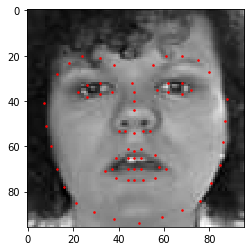

In [4]:
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.values[n, 0]
landmarks = landmarks_frame.values[n, 1:].astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [11]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [12]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].values.astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = image, landmarks

        if self.transform:
            sample = self.transform(sample)

        return sample

In [13]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return image, landmarks




class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        return torch.from_numpy(image).type(torch.float), torch.from_numpy(landmarks).type(torch.float)

In [14]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor())

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor())

In [15]:
def get_data_loaders(train_batch_size=64, val_batch_size=64):

    train_loader = DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=val_batch_size, shuffle=False
    )

    return train_loader, test_loader

In [443]:
class Net(Module):
    def __init__(self, activation=ReLU(), latent_size=200):
        super().__init__()
        self.conv1 = Conv2d(1, 8, 3, 1, 1)
        self.bn1 = BatchNorm2d(8)
        
        self.conv2 = Conv2d(8, 16, 3, 1, 1)
        self.bn2 = BatchNorm2d(16)
        
        self.conv3 = Conv2d(16, 32, 3, 1, 1)
        self.bn3 = BatchNorm2d(32)
        
        self.conv4 = Conv2d(32, 64, 3, 1, 1)
        self.bn4 = BatchNorm2d(64)
        
        self.dp_2d = Dropout2d(0.3)
        
        self.fc1 = Linear(64*6*6, 64*4)
        self.bn_1d = nn.BatchNorm1d(64*4)
        
        self.fc2 = Linear(64*4, 68*2)
        
        self.mp = MaxPool2d(2)        
        self.activation = activation
        self.dp_1d = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, 96, 96)
    
        y = self.conv1(x) 
        y = self.bn1(y)
        y = self.activation(y)
        y = self.mp(y)
        
        y = self.conv2(y)
        y = self.bn2(y)
        y = self.activation(y)
        y = self.mp(y)
        
        y = self.dp_2d(y)
        
        y = self.conv3(y)
        y = self.bn3(y)
        y = self.activation(y)
        y = self.mp(y)
        
        y = self.conv4(y)
        y = self.bn4(y)
        y = self.activation(y)
        y = self.mp(y)
        
        y = self.dp_2d(y)
        
        y = self.fc1(y.view(y.shape[0], -1))
        y = self.bn_1d(y)
        y = self.dp_1d(y)
        
        y = self.fc2(y)

        return y.view(x.shape[0], 68, 2)

In [460]:
network = Net(activation=nn.Tanh())
train_dataloader, test_dataloader = get_data_loaders()
writer = SummaryWriter(filename_suffix='first', logdir="out_logs")

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
criterion = MSELoss()
optim = torch.optim.Adam
learning_rate = 0.01
max_epochs = 50

optimizer = optim(network.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(network, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(
    network, metrics={"L2 loss": Loss(criterion), "L1 loss": Loss(L1Loss())}, device=device
)

training_history = {'l1':[],'l2':[]}
validation_history = {'l1':[],'l2':[]}
last_epoch = []

In [461]:
@trainer.on(Events.ITERATION_COMPLETED(every=10))
def log_training_loss(engine):
    writer.add_scalar("training/loss", engine.state.output, engine.state.iteration)
    writer.flush()


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    l2_train = metrics["L2 loss"]
    l1_train = metrics['L1 loss']
    last_epoch.append(0)
    training_history['l2'].append(l2_train)
    training_history['l1'].append(l1_train)
    writer.add_scalar("training/epoch_loss", l2_train, trainer.state.epoch)
    
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    l2 = metrics["L2 loss"]
    l1 = metrics['L1 loss']
    validation_history['l2'].append(l2)
    validation_history['l1'].append(l1)
    
    writer.add_scalar("validation/epoch_loss", l2, trainer.state.epoch)
    writer.flush()
    
    sys.stdout.write("\rTraining/Validation Results - Epoch: {}  Avg MSE: {:.2f} / {:.2f} Avg MAE: {:.2f} / {:.2f}"
          .format(trainer.state.epoch, l2_train, l2, l1_train, l1))

In [462]:
trainer.run(train_dataloader, max_epochs=max_epochs)

Training/Validation Results - Epoch: 50  Avg MSE: 3.60 / 4.66 Avg MAE: 1.34 / 1.480

State:
	iteration: 4900
	epoch: 50
	epoch_length: 98
	max_epochs: 50
	output: 8.091115951538086
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

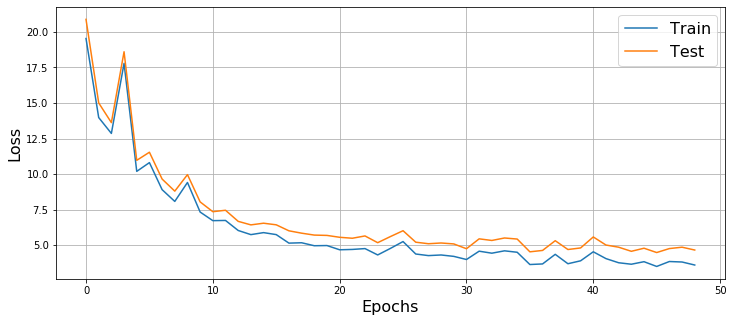

In [463]:
plt.figure(figsize=(12, 5))
plt.plot(training_history['l2'][1:], label='Train')
plt.plot(validation_history['l2'][1:], label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

Я испробовал большое число различных архитектур с разным количеством слоев.

1. На архитектуры содержащие только линейные слои средний MSE не уменьшался менее 18 для test'а 
2. Добавление сверточных слоев с max пулингом не улучшает ситуацию, хоть и удалось подобрать архитектуру при которой на 150-ой эпохе удалось незначительно уменьшить loss
3. Добавление батч-нормализации и дропаута значительно ускоряет обучение сети и стремитьльно улучшает качество  

(2, 96, 96)


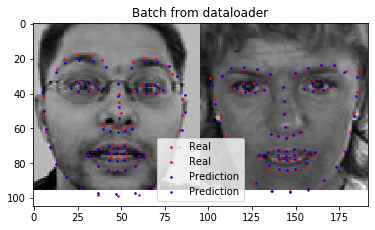

In [464]:
_, test_dataloader = get_data_loaders(val_batch_size=2)

images_batch = next(iter(test_dataloader))
x, y = images_batch
y_pred = network(x)
y_pred = y_pred.data.numpy()
show_landmarks_batch(images_batch, y_pred)

# Links

[Официальная страница ignite](https://pytorch.org/ignite/index.html)

[Официальная страница PyTorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning)


